<a href="https://colab.research.google.com/github/denncraft/AI_ML_notes/blob/main/%5BTitanic%5D%20Linear_model_and_neural_net_from_scratch_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This example here is based on fast.ai course and intended as a real life example for Gradient descent article.

We'll be using Kaggle's Titanic competition in this notebook, because it's very small and simple, but also has displays many of the tricky real-life issues that we need to handle in most practical projects.

First let's do the setup. We will be downloading data from kaggle. Kaggle is looking for credentials in kaggle.json file, so we need to create it first.

In [ ]:
!pip install kaggle

import os
from pathlib import Path

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"","key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

import zipfile, kaggle

path = Path('titanic')
if not path.exists():
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

We are going to use numpy and pytorch and pandas, lets set formatting so the ouput is readble

In [ ]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

We have downloaded the dataset file. Lets look at it

In [ ]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Certain recods have missing data (NaNs). Let's see how many of those we have using isna (is NaN) function and sum go see how many of those are there:

In [ ]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Many ML methods do not operate well with missing data, it may mess up the results soooo, lets replace them with most common values. Mode function returns just that - most common value for that column. Mode can return more than one value (in case of a tie) so let's take first element at location 0:

In [ ]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

Let's fill NaN with modes

In [ ]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Here's how we get a quick summary of all the numeric columns in the dataset:

In [ ]:
import numpy as np
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see that Fare contains mainly values of around 0 to 30, but there's a few really big ones. This is very common with fields contain monetary values, and it can cause problems for our model, because once that column is multiplied by a coefficient later, the few rows with really big values will dominate the result.

You can see the issue most clearly visually by looking at a histogram, which shows a long tail to the right:

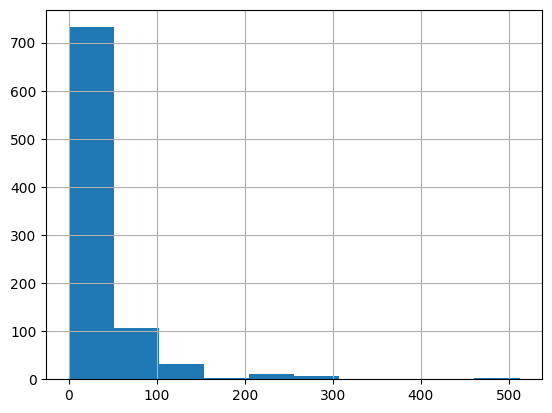

In [ ]:
df['Fare'].hist();

To fix this, the most common approach is to take the logarithm, which squishes the big numbers and makes the distribution more reasonable. Note, however, that there are zeros in the Fare column, and log(0) is infinite -- to fix this, we'll simply add 1 to all values first:

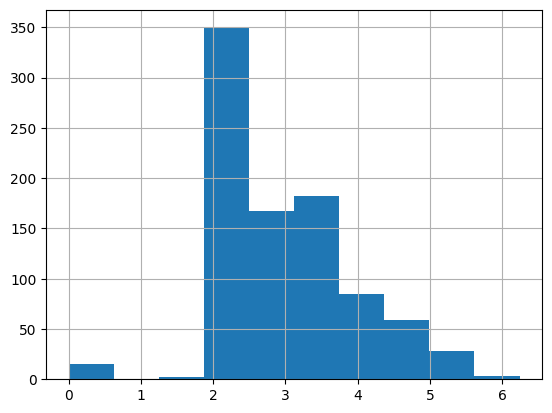

In [ ]:
df['LogFare'] = np.log(df['Fare']+1)
df['LogFare'].hist();

It looks from the describe() output like Pclass contains just 3 values, which we can confirm by looking at the Data Dictionary (which you should always study carefully for any project!)

In [ ]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [ ]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


We can't work with these values as they are non numerical. So we need to convert them to numbers. To do that we create dummy varialbles. It is a dummy colum for each value type, that will have 1 the value is the same for this row or 0 if it is different. So this will translate a text value to a numberical value, albeit in a form of multiple columns.

Pandas can create these automatically using get_dummies, which also remove the original columns. We'll create dummy variables for Pclass, even although it's numeric, since the numbers 1, 2, and 3 correspond to first, second, and third class cabins - not to counts or measures that make sense to multiply by. We'll also create dummies for Sex and Embarked since we'll want to use those as predictors in our model. On the other hand, Cabin, Name, and Ticket have too many unique values for it to make sense creating dummy variables for them.

In [ ]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

We can see that 5 columns have been added to the end -- one for each of the possible values of each of the three columns we requested, and that those three requested columns have been removed.

In [ ]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


Now we need to create our independend and dependent variables (predictors and target) in the form of pytorch tensors. Independent variables are those columns we are going to use to predeict if a passenger survived. These are Age, number of siblings, Fare and added columns

In [ ]:
from torch import tensor
t_dep = tensor(df.Survived)

indep_cols = ['Age', 'SibSp', 'LogFare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep


tensor([[22.0000,  1.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  3.4054,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
      

Let's check the tensor size

In [ ]:
t_indep.shape

torch.Size([891, 11])

Now we are going to manually do a sigle step of calculating predictions and calculate loss. We initialize coefficinets of our model with random values from -0.5 to 0.5

In [ ]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103])

We now calculate our predictions by multiplying all columns by corresponding coefficients and summing them up. These predictions are going to be random as we pick random coefficients at first. That is fine as a first step - we need to start somewhere!

In [ ]:
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.5084,  -0.2262,  -0.0000,  -0.0000,   0.0000,   0.3136,   0.0000,  -0.0000,   0.2103],
        [-17.5902,   0.1386,   1.0312,  -0.0000,  -0.2632,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000],
        [-12.0354,   0.0000,   0.5273,  -0.0000,  -0.2632,  -0.0000,   0.0000,   0.3136,   0.0000,  -0.0000,   0.2103],
        [-16.2015,   0.1386,   0.9614,  -0.0000,  -0.2632,  -0.3147,   0.0000,   0.0000,   0.0000,  -0.0000,   0.2103],
        [-16.2015,   0.0000,   0.5306,  -0.2262,  -0.0000,  -0.0000,   0.0000,   0.3136,   0.0000,  -0.0000,   0.2103],
        [-11.1096,   0.0000,   0.5413,  -0.2262,  -0.0000,  -0.0000,   0.0000,   0.3136,   0.0000,  -0.4392,   0.0000],
        [-24.9966,   0.0000,   0.9558,  -0.2262,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.0000,  -0.0000,   0.2103],
        ...,
        [-11.5725,   0.0000,   0.5024,  -0.2262,  -0.0000,  -0.0000,   0.0000,   0.3136,   0.0000,  -0.0000,   0.2103],
        [-18.0531,   0.0000

We've got a problem here. The sums of each row will be dominated by the first column, which is Age, since that's bigger on average than all the others. Let's normalize all the columns to contain numbers from 0 to 1, by dividing each column by its max():

In [ ]:
vals,_ = t_indep.max(dim=0)
t_indep = t_indep / vals

And summing up:

In [ ]:
preds = (t_indep*coeffs).sum(axis=1)
preds[:10]

tensor([ 0.2692, -0.3354,  0.1947, -0.3988,  0.1802, -0.4039, -0.4899,  0.4575,  0.2007,  0.5732])

As mentioned in the article above, we take an average of all differences between predicted and actual values to calculate the loss:

In [ ]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5755)

To make code more readable lets put organize it into functions:

In [ ]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

We're going to do a single "epoch" of gradient descent manually. The only thing we're going to automate is calculating gradients, because let's face it that's pretty pointless to do by hand! To get PyTorch to calculate gradients, we'll need to call requires_grad_() on our coeffs:

In [ ]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103], requires_grad=True)

In [ ]:
loss = calc_loss(coeffs, t_indep, t_dep)
# Use backward() to ask PyTorch to calculate gradients now
loss.backward()
coeffs.grad

tensor([-0.0338,  0.0073, -0.0877,  0.1448, -0.1975, -0.2424,  0.0090,  0.1807, -0.0786, -0.0864,  0.1122])

Note that each time we call backward, the gradients are actually added to whatever is in the .grad attribute. Let's try running the above steps again:

In [ ]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0677,  0.0146, -0.1754,  0.2896, -0.3951, -0.4848,  0.0180,  0.3614, -0.1571, -0.1728,  0.2245])

As you see, our .grad values are have doubled. That's because it added the gradients a second time. For this reason, after we use the gradients to do a gradient descent step, we need to set them back to zero.
Note that x.sub_(y) subtracts y from x in-place. In PyTorch, any method that ends in _ changes its object in-place. Similarly, x.zero_() sets all elements of x tensor to zero.

In [ ]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5042)


To train our model and improve coefficients we need training data and validation data to validate the model after training. We have all data in one chunk so let's use RandomSplitter to get indices that will split our data into training and validation sets and created both sets:

In [ ]:
from fastai.data.transforms import RandomSplitter
train_split, validation_split=RandomSplitter(seed=42)(df)

trn_indep = t_indep[train_split]
val_indep = t_indep[validation_split]
trn_dep, val_dep = t_dep[train_split],t_dep[validation_split]
len(trn_indep), len(val_indep)

(713, 178)

We'll create functions for the three things we did manually above: updating coeffs, doing one full gradient descent step, and initilising coeffs to random numbers. lr stand for Learning Rate, read here about it  https://medium.com/innova-technology/gradient-descent-complete-explanation-495ec75fee7b:

In [ ]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

Lets do somne training!

In [ ]:
coeffs = train_model(18, lr=0.2)

0.567; 0.530; 0.496; 0.466; 0.439; 0.416; 0.395; 0.376; 0.359; 0.344; 0.332; 0.324; 0.326; 0.314; 0.316; 0.308; 0.306; 0.303; 

Our loss is printed at the end of every step, and it is going down! It is working!

And now lets look at the coefficinet for each column:

In [ ]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2805),
 'SibSp': tensor(0.0941),
 'LogFare': tensor(0.4649),
 'Sex_male': tensor(-0.4320),
 'Sex_female': tensor(0.2574),
 'Pclass_1': tensor(0.2138),
 'Pclass_2': tensor(0.3726),
 'Pclass_3': tensor(0.2148),
 'Embarked_C': tensor(0.3343),
 'Embarked_Q': tensor(-0.1923),
 'Embarked_S': tensor(0.2238)}

# **Measuring accuracy**

---



The Kaggle competition is scored by accuracy, not the eroor (loss). Accuracy is the proportion of rows where we correctly predict survival. Let's see how accurate we were on the validation set. First, calculate the predictions and assume that anything abouve 0.5 is predicting survival:

In [ ]:
preds = calc_preds(coeffs, val_indep)
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False, False,  True, False])

Our accuracy is an average of that:

In [ ]:
results.float().mean()

tensor(0.7697)

Let's put this into a function:

In [ ]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.8258)

Looking at our predictions, there's one problem -- some of our predictions of the probability of survival are >1, and some are <0, which doesn't make sense and screwing up our model. So let's clamp those values using a function called sigmoid. It has a minimum at zero and maximum at one, and is defined as follows:

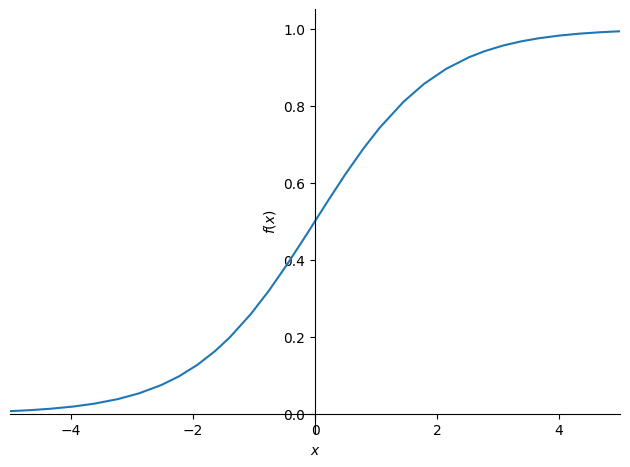

In [ ]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

Let's use it in our calc_preds

In [ ]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [ ]:
coeffs = train_model(lr=100)
acc(coeffs)

0.519; 0.326; 0.306; 0.212; 0.204; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

tensor(0.8258)

As you can see accuracy has improved somewhat.

In [ ]:
show_coeffs()

{'Age': tensor(-1.4947),
 'SibSp': tensor(-1.2002),
 'LogFare': tensor(0.6261),
 'Sex_male': tensor(-10.1906),
 'Sex_female': tensor(8.2849),
 'Pclass_1': tensor(2.9183),
 'Pclass_2': tensor(2.3261),
 'Pclass_3': tensor(-6.1742),
 'Embarked_C': tensor(1.7236),
 'Embarked_Q': tensor(1.8801),
 'Embarked_S': tensor(-4.9689)}

These coefficients seem reasonable -- in general, older people and males were less likely to survive, and first class passengers were more likely to survive.

# **Using matrix product**


---

We can make things quite a bit neater...

Take a look at the inner-most calculation we're doing to get the predictions:

In [ ]:
(val_indep*coeffs).sum(axis=1)

tensor([ 12.3027, -14.7157, -14.8782, -12.7372, -13.0356, -13.3085,   4.0272,   5.3838, -21.7143,   3.5519, -21.7119, -14.9600, -21.3080,
          3.7614, -21.7668, -12.7492, -13.1229,   5.5057, -13.2313,  -3.2096, -21.5628, -12.9547,  12.5214,   5.0157, -21.4981, -14.7596,
         -2.7765, -13.0668, -21.4237,   3.7600,   5.5706,  -3.5191, -21.4694, -21.6825,  12.1906,  -3.1471, -12.7625,  12.9050, -21.5611,
         -3.2557, -12.9433, -21.5611, -13.1846,  12.7651, -21.4863,  -3.2524, -21.4130, -21.6372, -14.7252,  -3.0575,  -6.0618, -21.8638,
        -21.7530, -21.5915, -13.0741, -13.1862, -14.7155, -21.8747, -21.5050, -21.5813,  -5.7723, -21.5920, -13.3913, -21.5064,   5.0007,
        -12.1960, -13.0170, -21.7388, -15.1009,   5.0697, -21.6002,   3.6655, -13.1675, -21.5462, -12.3592, -21.4147, -21.5611, -12.6486,
        -12.9235, -13.4333, -12.7820,  12.7935, -21.5441, -21.5703,   4.9530,  -6.3817,  -5.5636,   6.3039,  11.9844, -12.9983, -21.7071,
        -21.5611,  12.8354, -14.99

this is the same as:

In [ ]:
val_indep@coeffs

tensor([ 12.3027, -14.7157, -14.8782, -12.7372, -13.0356, -13.3085,   4.0272,   5.3838, -21.7143,   3.5519, -21.7119, -14.9600, -21.3080,
          3.7614, -21.7668, -12.7492, -13.1229,   5.5057, -13.2313,  -3.2096, -21.5628, -12.9547,  12.5214,   5.0157, -21.4981, -14.7596,
         -2.7765, -13.0668, -21.4237,   3.7600,   5.5706,  -3.5191, -21.4694, -21.6825,  12.1906,  -3.1471, -12.7625,  12.9050, -21.5611,
         -3.2557, -12.9433, -21.5611, -13.1846,  12.7651, -21.4863,  -3.2524, -21.4130, -21.6372, -14.7252,  -3.0575,  -6.0618, -21.8638,
        -21.7530, -21.5915, -13.0741, -13.1862, -14.7155, -21.8747, -21.5050, -21.5813,  -5.7723, -21.5920, -13.3913, -21.5064,   5.0007,
        -12.1960, -13.0170, -21.7388, -15.1009,   5.0697, -21.6002,   3.6655, -13.1675, -21.5462, -12.3592, -21.4147, -21.5611, -12.6486,
        -12.9235, -13.4333, -12.7820,  12.7935, -21.5441, -21.5703,   4.9530,  -6.3817,  -5.5636,   6.3039,  11.9844, -12.9983, -21.7071,
        -21.5611,  12.8354, -14.99

It also turns out that this is much faster, because matrix products in PyTorch are very highly optimised.

Let's use this to replace how calc_preds works:

In [ ]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In order to do matrix-matrix products (which we'll need in the next section), we need to turn coeffs into a column vector (i.e. a matrix with a single column), which we can do by passing a second argument 1 to torch.rand(), indicating that we want our coefficients to have one column:

In [ ]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

We'll also need to turn our dependent variable into a column vector, which we can do by indexing the column dimension with the special value None, which tells PyTorch to add a new dimension in this position:

In [ ]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

We can now train our model as before:

In [ ]:
coeffs = train_model(lr=100)

0.513; 0.323; 0.291; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

Same accuracy:

In [ ]:
acc(coeffs)

tensor(0.8258)

# **A neural network**


---



Now we've come to implementing neural network:

First, we'll need to create coefficients for each of our layers. Our first set of coefficients will take our n_coeff inputs, and create n_hidden outputs. We can choose whatever n_hidden we like -- a higher number gives our network more flexibility, but makes it slower and harder to train. So we need a matrix of size n_coeff by n_hidden. We'll divide these coefficients by n_hidden so that when we sum them up in the next layer we'll end up with similar magnitude numbers to what we started with.

Then our second layer will need to take the n_hidden inputs and create a single output, so that means we need a n_hidden by 1 matrix there. The second layer will also need a constant term added.

In [ ]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

Now we have our coefficients, we can create our neural net. The key steps are the two matrix products, indeps@l1 and res@l2 (where res is the output of the first layer). The first layer output is passed to [F.relu](https://medium.com/innova-technology/rectifier-linear-unit-relu-in-neural-networks-3bd78e10437d) (that's our non-linearity), and the second is passed to torch.sigmoid as before.

In [ ]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

Finally, now that we have more than one set of coefficients, we need to add a loop to update each one and train:

In [ ]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()


coeffs = train_model(lr=20)

0.554; 0.448; 0.348; 0.256; 0.214; 0.213; 0.222; 0.214; 0.212; 0.201; 0.205; 0.211; 0.196; 0.194; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 

In [ ]:
acc(coeffs)

tensor(0.8258)

Accuracy is the same, as expected.

# **Deep learning**


---


The neural net in the previous section only uses one hidden layer, so it doesn't count as "deep" learning. But we can use the exact same technique to make our neural net deep, by adding more matrix multiplications.

First, we'll need to create additional coefficients for each layer:

In [ ]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

You'll notice here that there's a lot magic **constants** to get the random numbers in just the right ranges... When you train the model in a moment, you'll see that the tiniest changes to these initialisations can cause our model to fail to train at all! This is a key reason that deep learning failed to make much progress in the early days -- it's very finicky to get a good starting point for our coefficients.

Our deep learning calc_preds looks much the same as before, but now we loop through each layer, instead of listing them separately:

In [ ]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

We also need a minor update to update_coeffs since we've got layers and consts separated now:

In [ ]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

coeffs = train_model(lr=1.4)
acc(coeffs)

0.546; 0.479; 0.380; 0.344; 0.456; 0.366; 0.338; 0.365; 0.370; 0.349; 0.316; 0.310; 0.307; 0.300; 0.296; 0.293; 0.290; 0.287; 0.283; 0.280; 0.277; 0.274; 0.273; 0.277; 0.266; 0.263; 0.261; 0.261; 0.257; 0.260; 

tensor(0.8258)

Accuracy is the same again.

# **Final thoughts**


---


It's actually pretty cool that we've managed to create a real deep learning model from scratch and trained it to get over 80% accuracy on this task, all in the course of a single notebook!

The "real" deep learning models that are used in research and industry look very similar to this, and in fact if you look inside the source code of any deep learning model you'll recognise the basic steps are the same.

The biggest differences in practical models to what we have above are:

How initialisation and normalisation is done to ensure the model trains correctly every time
Regularization (to avoid over-fitting)
Modifying the neural net itself to take advantage of knowledge of the problem domain
Doing gradient descent steps on smaller batches, rather than the whole dataset.
I'll be adding notebooks about all these later, and will add links here once they're ready.
